**Modelo de red neuronal GRU**
Este archivo consta de los codigos de:
* 1.Carga de librerias y datos
* 2.Proceso de entrenamiento
  * 2.1. Separacion de datos en train y test
  * 2.2 Modelo GRU
* 3.Evaluacion del modelo
* 4.Exportar resultados


#1.Carga de Librerias y Datos


*Se importan los módulos necesarios para trabajar*

##Carga de librerias

In [57]:
#Pandas es utilizado para leer los set de datos
import pandas as pd
#Numpy es utilizado para generar las series de datos a graficar
import numpy as np
#Seaborn es utilizado para generar los gráficos
import seaborn as sns
import matplotlib.pyplot as plt
#Se importan modulos estadisticos para generar test de hipotesis, entre otros
from sklearn.preprocessing import StandardScaler,MinMaxScaler
#Ignorar warnings
import warnings
warnings.filterwarnings("ignore")

#Dividir arreglos o matrices en subconjuntos aleatorios de tren y prueba
from sklearn.model_selection import train_test_split

#Biblioteca de Redes Neuronales
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential,model_from_json
from keras.layers import Dropout, LSTM, Dense, Activation,Input,GRU
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint

from hyperopt import Trials, STATUS_OK, tpe, hp, fmin, space_eval
from sklearn.model_selection import cross_val_score, KFold, cross_val_predict, TimeSeriesSplit
import os

In [33]:
# Para acceder a los archivos del gdrive
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [34]:
cd /content/gdrive/MyDrive/Tesis/Datos-ConsumoElectrico

/content/gdrive/MyDrive/Tesis/Datos-ConsumoElectrico


##Se obtiene conjunto de datos

In [35]:
predictor_variables=pd.read_csv('predictor_variables.csv' ,index_col='dt')
target_variables=pd.read_csv('target_variables.csv' ,index_col='dt')

In [36]:
#Setear semilla
np.random.seed(42)

#2.Proceso de entrenamiento

**Se establece los parametros de:**

In [37]:
#Se establece porcentaje de usado para test
PORCENTAJE_TEST=0.2

#Se define la cantidad de intentos de la optimizacion bayesiana
INTENTOS=100

##2.1. Separacion de data en train y test

In [38]:
#Se separa conjunto en entrenamiento y prueba; sin aleatoriedad
X_train, X_test, Y_train, Y_test = train_test_split(predictor_variables, target_variables, test_size=PORCENTAJE_TEST, shuffle=False)

shape_x_test=X_test.shape
shape_y_test=Y_test.shape

print("Separacion de datos terminada!")

Separacion de datos terminada!


In [41]:
#Se da formato de entradas como: Un tensor 3D con la forma [batch, timesteps, feature]
X_train=np.array(X_train)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))

Y_train_s=np.array(Y_train)
Y_train_s = Y_train_s.reshape((Y_train_s.shape[0], 1, Y_train_s.shape[1]))

X_test=np.array(X_test)
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

Y_test=np.array(Y_test)
Y_test = Y_test.reshape((Y_test.shape[0], 1, Y_test.shape[1]))

#2.2 Modelo GRU

In [39]:
import time

In [40]:
# Ajustar parámetros para reproducibilidad del entrenamiento
keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

In [42]:
# Función para crear el modelo GRU
def create_model(neurons, dropout,layers,learning_rate):

    #Creacion de la arquitectura GRU
    model = Sequential()
    #Capas ocultas
    for i in range(layers):
        model.add(GRU(units=neurons, return_sequences=(layers-1), input_dim=X_train.shape[2]))
        model.add(Dropout(dropout))
    #Capa de salida
    model.add(Dense(1))

    #Se configura el proceso de entrenamiento del modelo y metricas de evaluacion
    model.compile(loss='mean_squared_error',
                  optimizer=Adam(learning_rate=learning_rate),
                  metrics = [tf.keras.metrics.MeanSquaredError(),
                            tf.keras.metrics.RootMeanSquaredError(),
                            tf.keras.metrics.MeanAbsoluteError(),
                            tf.keras.metrics.MeanAbsolutePercentageError()]
                  )
    return model

In [43]:
def objective(params):

    # Definir los hiperparámetros a optimizar
    epochs = params['epochs']
    batch_size = params['batch_size']
    optimizer = params['optimizer']
    neurons  = params['neurons']
    dropout  = params['dropout']
    layers  = params['layers']
    learning_rate = params['learning_rate']

    #kf = KFold(n_splits=5)
    tscv = TimeSeriesSplit(n_splits=5)
    scores = []
    times=[]
    models=[]
    scores_test=[]
    aux=1000

    #Se detiene el entrenamiento en el momento que se observe un incremento en el valor del error de validación.
    early_stop = EarlyStopping(monitor='val_loss', patience=30, mode='min',restore_best_weights=True)
    print(f"{neurons},{layers},{batch_size}")
    #Validacion cruzada
    for train_index, test_index in tscv.split(X_train):
      X_train_, X_test_ = X_train[train_index], X_train[test_index]
      y_train_, y_test_ = Y_train_s[train_index], Y_train_s[test_index]

      # Crear el modelo de GRU
      model = create_model(int(neurons), float(dropout),int(layers),float(learning_rate))

      #Entrenamiento
      start = time.time()
      hist=model.fit(X_train_, y_train_, batch_size=int(batch_size), epochs=int(epochs), verbose=0, validation_data=(X_test_, y_test_),callbacks=[early_stop],use_multiprocessing=True)
      end = time.time()

      #Evaluacion del modelo
      score = model.evaluate(X_test_, y_test_, verbose = 0)
      scores.append(score)
      #Error en conjunto de test
      score_test = model.evaluate(X_test, Y_test, verbose = 0)
      scores_test.append(score_test)

      #guardar modelo keras
      models.append(model)

      if(score_test[0]<aux):
        aux=score_test[0]
        best_model=model
        hist_=hist

      #Tiempo de la validadion cruzada
      time_val= end- start
      times.append(time_val)

    return {'loss': np.mean(scores),
            'status': STATUS_OK,
            'model': best_model,
            'params': params,
            'time':times,
            'hist':hist_,
            'scores_test': scores_test,
            'scores': scores,
            'models':models}

In [44]:
#Se define el espacio de busqueda de hiperparametros para el modelo
space = {
    'epochs': 800,
    'batch_size':  hp.quniform('batch_size', 10, 100, 10),
    'optimizer':'adam',
    'neurons': hp.quniform('neurons', 100, 800, 20),
    'dropout':hp.uniform('dropout', 0.4, 0.7),
    'layers': hp.quniform('layers', 1, 3, 1),
    'learning_rate': hp.uniform('learning_rate', 0.0001, 0.0005),
}

In [45]:
print("Se inicia entrenamiento...")
#Optimización bayesiana
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=INTENTOS, trials=trials)
print("Modelo entrenado!")

Se inicia entrenamiento...
360.0,2.0,50.0
100%|██████████| 1/1 [01:08<00:00, 68.59s/trial, best loss: 52.28040707468986]
Modelo entrenado!


In [46]:
#Obtener el valor de la función objetivo del mejor ensayo
best_trial = trials.best_trial
hist = best_trial['result']['hist']
best_model = best_trial['result']['model']
scores_model = best_trial['result']['scores_test']

In [47]:
# Obtener una lista de los resultados de todas las evaluaciones
all_results = [trial['result'] for trial in trials]

In [48]:
# Mejores hiperparámetros encontrados
best_params = space_eval(space, best)
best_params

{'batch_size': 50.0,
 'dropout': 0.4115646127230011,
 'epochs': 800,
 'layers': 2.0,
 'learning_rate': 0.00027204648967710455,
 'neurons': 360.0,
 'optimizer': 'adam'}

#3.Evaluacion del modelo

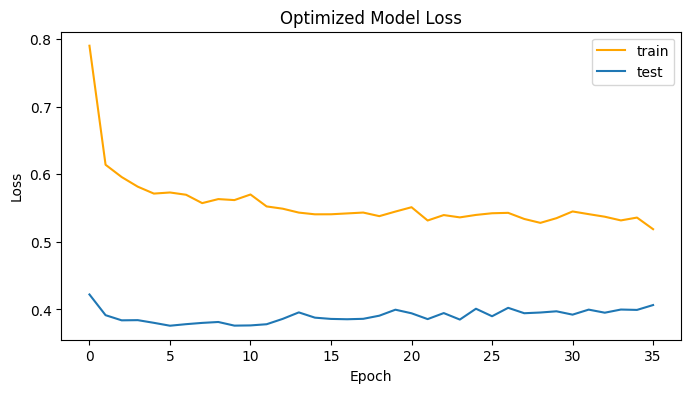

In [49]:
plt.figure(figsize=(8,4))
plt.plot(hist.history['loss'], color = 'orange')
plt.plot(hist.history['val_loss'])
plt.title('Optimized Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

In [50]:
#Se realiza prediccion
results = best_model.predict(X_test)

results = results.reshape(shape_y_test)
y_grafico = Y_test.reshape(shape_y_test)

9/9 [==============================] - 1s 4ms/step


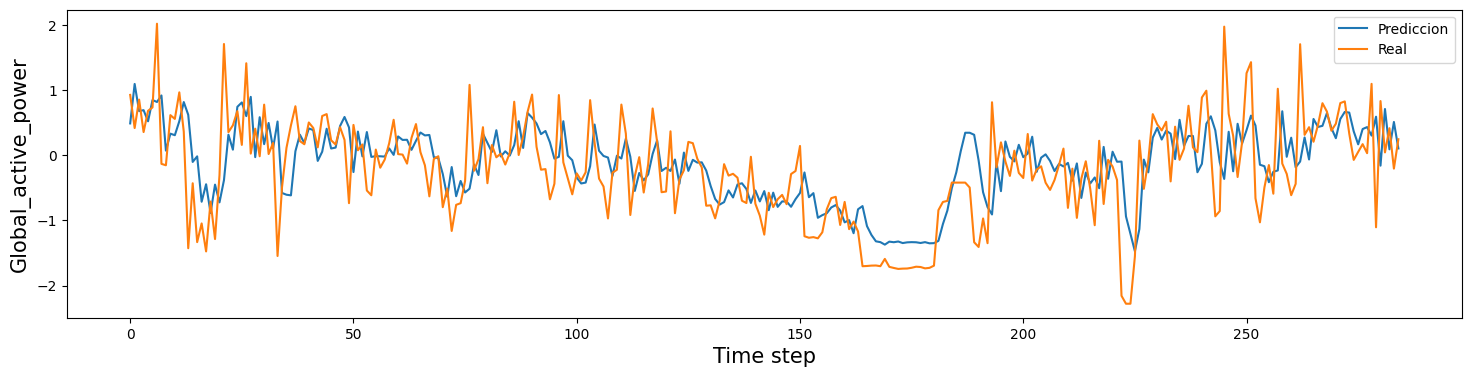

In [51]:
#Grafico de prediccion con el valor real
tiempo=[x for x in range(y_grafico.shape[0])]
plt.figure(figsize=(18,4))
plt.plot(tiempo,results)
plt.ylabel('Global_active_power', size=15)
plt.plot(tiempo,y_grafico)
plt.xlabel('Time step', size=15)
plt.legend(['Prediccion','Real'])
plt.show()

In [52]:
#Metricas de precision del modelo keras
score = best_model.evaluate(X_test, Y_test, verbose = 0)
print('MSE:', score[1])
print('RMSE:', score[2])
print('MAE:', score[3])
print('MAPE:', score[4])

MSE: 0.3836117088794708
RMSE: 0.6193639636039734
MAE: 0.46099814772605896
MAPE: 223.80018615722656


#4.Exportar resultados

Se guardan los resultados la optimizacion bayesiana

In [53]:
#Del objeto all_results donde estan los resultados de cada trial de la optimizacion bayesiana se obtiene los parametros para exportalos a un csv
results=[]
trial=0 #Nº de intento de optimizacion bayesiana

for result in all_results:
  k=0 #validacion cruzada
  trial+=1
  i=0
  for time in result['time']:
    k+=1
    nameModel = "GRU_CE"+"_"+str(trial)+"_"+str(k) + "_"+str(result['params']['epochs'])+"_"+str(result['params']['batch_size'])+"_"+str(result['params']['layers'])+"_"+str(result['params']['neurons'])+"_"+str(round(result['params']['dropout'],2))+"_"+str(result['params']['optimizer'])+"_"+str(result['params']['learning_rate'])
    results.append([nameModel,trial,k,time,
                    result['scores_test'][i][0],result['scores_test'][i][2],result['scores_test'][i][3],result['scores_test'][i][4]]
                   )
    i+=1

In [54]:
#Se crea dataframe
results_csv=pd.DataFrame(results,columns=['nameModel','trial_optimizacion_bayesiana','Step_validacion','time','MSE','RMSE','MAE','MAPE'])

In [55]:
results_o = results_csv.sort_values(by='MSE', ascending=True)
results_o.head(5)

,nameModel,trial_optimizacion_bayesiana,Step_validacion,time,MSE,RMSE,MAE,MAPE
4,GRU_CE_1_5_800_50.0_2.0_360.0_0.41_adam_0.0002...,1,5,12.810508,0.383612,0.619364,0.460998,223.800186
3,GRU_CE_1_4_800_50.0_2.0_360.0_0.41_adam_0.0002...,1,4,20.698195,0.391847,0.625977,0.463639,241.833984
2,GRU_CE_1_3_800_50.0_2.0_360.0_0.41_adam_0.0002...,1,3,12.310935,0.428523,0.654617,0.496347,269.332825
0,GRU_CE_1_1_800_50.0_2.0_360.0_0.41_adam_0.0002...,1,1,8.250882,0.436033,0.660328,0.498395,272.308075
1,GRU_CE_1_2_800_50.0_2.0_360.0_0.41_adam_0.0002...,1,2,10.467596,0.526639,0.725699,0.560018,343.245392


In [58]:
# Exportar el DataFrame como CSV
folder_path = '/content/gdrive/MyDrive/Tesis/Datos-ConsumoElectrico/Resultados_csv'
csv_filename = 'results_GRU_CE'
csv_path = os.path.join(folder_path, csv_filename)
results_csv.to_csv(csv_path, index=False)

Se guarda cada modelo keras en un objeto Json

In [59]:
# Ruta de la carpeta que deseas crear
carpeta_destino ='/content/gdrive/MyDrive/Tesis/Datos-ConsumoElectrico/Resultados_Modelos/results_GRU'

# Verificar si la carpeta ya existe
if not os.path.exists(carpeta_destino):
    # Crear la carpeta si no existe
    os.makedirs(carpeta_destino)

In [60]:
#Del objeto all_results donde estan los resultados de cada trial de la optimizacion bayesiana se obtiene los modelos para exportalos a un Json
results=[]
trial=0 #Nº de intento de optimizacion bayesiana

for result in all_results:
  k=0 #validacion cruzada
  trial+=1
  i=0
  for model in result['models']:
    k+=1
    nameModel = "GRU_CE"+"_"+str(trial)+"_"+str(k) + "__"+str(result['params']['epochs'])+"_"+str(result['params']['batch_size'])+"_"+str(result['params']['layers'])+"_"+str(result['params']['neurons'])+"_"+str(round(result['params']['dropout'],2))+"_"+str(result['params']['optimizer'])+"_"+str(result['params']['learning_rate'])
    model_json = model.to_json()
    nameModel_j=nameModel+"."+"json"
    ruta = os.path.join(carpeta_destino, nameModel + ".json")
    with open(ruta, "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    save_w=nameModel+"."+"h5"
    weights_path = os.path.join(carpeta_destino, save_w)
    model.save_weights(weights_path)
    i+=1